In [ ]:
# %load ./Solution/database.py
import psycopg2
import glob
import os
import pandas as pd
from io import StringIO
from postgis.psycopg import register


def import_input():
    con = psycopg2.connect("host='localhost' port='5432' dbname='infocup'")
    cursor = con.cursor()
    cursor.execute('truncate table stations cascade;')
    f = open(r'../Eingabedaten/Tankstellen.csv', 'r')
    cursor.copy_from(f, 'stations', sep=';')
    f.close()
    con.commit()
    os.chdir('../Eingabedaten/Benzinpreise')
    files = glob.glob('*.csv')
    counter = 0
    for price_file in files:
        station_id = int(os.path.splitext(price_file)[0])
        df = pd.read_csv(price_file, delimiter=';')
        df['station_id'] = station_id
        buf = StringIO()
        df.to_csv(buf, header=False, index=False)
        buf.seek(0)
        cursor.copy_from(buf, 'prices', sep=',', columns=('time_stamp', 'price', 'station_id'))
        con.commit()
        counter += 1
        if counter % 100 == 0:
            print(str(counter) + ' / ' + str(len(files)))
    con.close()
    print('done')


def get_highways():
    con = psycopg2.connect("host='localhost' port='5432' dbname='infocup'")
    register(con)
    cursor = con.cursor()

    cursor.execute("""select row_to_json(fc)::text
    from (select 'FeatureCollection' as type, array_to_json(array_agg(f)) as features
    from  
    (select 'Feature' as type, 
    (select l from (select ref as name) as l) as properties, 
    st_asgeojson(st_collect(linestring))::json as geometry 
    from ways where tags -> 'highway' = 'motorway' group by ref) as f) as fc;""")
    result = cursor.fetchone()
    con.commit()
    con.close()
    return result


if __name__ == '__main__':
    # import_input()
    get_highways()


'/home/nero/dhbw/informatikcup/InformatiCup2018'

/home/nero/infocup-env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/nero/infocup-env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


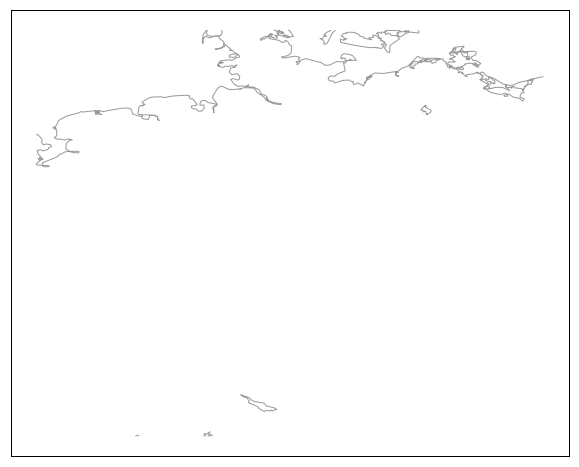

In [11]:
import geojson
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

plt.clf()
ax = plt.figure(figsize=(10,10)).add_subplot(111)
m = Basemap(epsg=4326, resolution='i',llcrnrlon=5, llcrnrlat=47, urcrnrlon=15, urcrnrlat=55)
m.drawmapboundary(fill_color='white', zorder=-1)
m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=14)
m.drawmeridians(np.arange(0., 360., 60.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=14)
m.drawcoastlines(color='0.6', linewidth=1)

ax.axis('scaled')
plt.draw()
plt.show()